# <center> Is certain topics are funnier than other ?
<br/><br/>
<center>
    <img src="data/newyorker_caption_contest_virgin/images/666.jpg" alt="New Yorker Cartoon" style="width:300px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>

---

# <center>Milestone 3 CYCY : Table of content</center>

0. **Imports, initialisations**

1. **A**
   - 1.1. 
   - 1.2. 
   - 1.3. 
   - 1.4. 
   - 1.5. 

2. **B**
    - 2.1. 

3. **C**
    - 3.1. 

4. **D**
   - 4.1. **E**
   - 4.2. **F**
   - 4.3. **G**

## 0. Imports, initialisations

In case an import cannot be imported run this:

In [9]:
import importlib
import src.utils.paths as p
importlib.reload(p)

<module 'src.utils.paths' from 'c:\\Users\\cyrie\\OneDrive\\Documents\\EPFL\\2025_MA_1\\ADA\\ada-2025-project-adacore42\\src\\utils\\paths.py'>

Getting the project root directory path.

In [13]:
from pathlib import Path
import sys
import os

try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))



from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH, STORED_MAIN_DIR_PATH
print(DATA_PREPARATION_PY_PATH.resolve()) #If works: ...../ADAcore42/src/data/DataPreparation.py


Root folder detected at: c:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42
C:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42\_Other\cycy_analysis\src\data\DataPreparation.py


In [11]:
import pandas as pd
import pickle
import json
import ast
from collections import Counter

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display, Markdown

# data processing
#from src.data.tokenise import load_data, apply_preprocessing, save_data
#from src.data.extract_nouns import load_data, apply_noun_extraction, save_noun_data

# utils
from src.utils.general_utils import *
#from src.utils.gui import plots_gui as pg
from src.utils.function_axis_1 import plot_global_vote_distribution
from src.utils.function_axis_1 import compute_funny_ranking

# scripts
import src.scripts.descriptive_stats_tasks as dst
from src.scripts.axis2 import *

# models
from src.models.gender_analysis import GenderAnalysis
from src.models.similarity_analysis import SimilarityModel, CaptionClustering, SimilarHumorAnalysis
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

%matplotlib inline

### 1.4. Executing the DataPreparation.ipynb file

This cell executes all what's been described in section 1.1. We did not want to copy paste the code here to keep this result file clean, but for any verification about the code, please refer to ```src\data\DataPreparation.py```.

In [31]:
#%run {DATA_PREPARATION_PY_PATH.resolve()}

In [22]:
STORED_CLEAN_DATAPREP_PKL_PATH = STORED_MAIN_DIR_PATH / "cleaned_data_prepared.pkl"

# Chargement du fichier pickle
with open(root / STORED_CLEAN_DATAPREP_PKL_PATH, "rb") as f:
    lemmatized_data = pickle.load(f)

### Loading of preprocessed data's pickle :
stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH

with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)


# Objects extraction
dataA = data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

## 3.2. Plots

In [15]:
print(contest_index2absolute_index(801))
print(contest_index2absolute_index(606))
print(contest_index2absolute_index(610))
print(contest_index2absolute_index(611))

289
94
98
99


In [ ]:
# TOPIC MODELLING: FINDING TOPICS WITH BERT AND LABELING EACH CAPTIONS WITH A TOPIC, THEN SAVING RESULTS

# Load captions
contest_idx_list = [289] #[289, 94, 98, 99]
data_topics = []
data_topic_info = []

for contest_idx in contest_idx_list:
    data_m = dataA[contest_idx].copy()
    captions = data_m['caption'].tolist()

    # Sentence embedding model
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    # Compute caption embeddings
    embeddings = embedding_model.encode(captions, show_progress_bar=True)

    # Create BERTopic model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        min_topic_size=10,          # has been tuned (smaller -> more topics)
        n_gram_range=(1, 2),        # bigrams are important for humor
        verbose=True
    )

    # Fit model using embeddings
    topics, probs = topic_model.fit_transform(captions, embeddings)
    topic_model.get_topic_info().head()

    # Save results 
    df_topics = pd.DataFrame({
        "caption": captions,
        "topic": topics,
    })

    df_topic_info = topic_model.get_topic_info()

    data_topics.append(df_topics)
    data_topic_info.append(df_topic_info)

    #df_topics.to_csv(os.path.join("_Other", "cycy_analysis", f"caption_labeled_topics_{contest_idx}.csv"), index=False)
    #df_topic_info.to_csv(os.path.join("_Other", "cycy_analysis", f"info_topics_{contest_idx}.csv"), index=False)

with open("caption_topics.pkl", "wb") as f:
    pickle.dump({"data_topics" : data_topics, "data_topic_info": data_topic_info}, f)

Batches: 100%|██████████| 140/140 [00:26<00:00,  5.36it/s]
2025-12-12 19:14:34,225 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-12 19:14:41,043 - BERTopic - Dimensionality - Completed ✓
2025-12-12 19:14:41,049 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-12 19:14:41,501 - BERTopic - Cluster - Completed ✓
2025-12-12 19:14:41,546 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-12 19:14:41,914 - BERTopic - Representation - Completed ✓


'with open(STORED_DATAPREP_PKL_PATH, "rb") as f:\n    data = pickle.load(f)\n'

In [38]:
agg_topic_289 = {
  "checkmate_win_lose": [-1,0,1,5,7,10,11,16,18,19,20,24,32,37,41,45,49,53,60],
  "chess_mechanics_pieces": [2,3,4,7,18,20,27,30,31,35,41,46,59,66,79],
  "death_grim_reaper_afterlife": [10,11,14,19,24,31,36,39,40,47,51,57,63,69],
  "time_endgame_clock": [8,14,17,20,60,64],
  "pop_culture": [21,23,25,33,38,43,55,56,61,70,71,75,78,77],
  "bureaucracy_taxes_insurance": [6,52,80],
  "deals_bets_rematches": [15,22,48,50,62,74],
  "body_parts": [12,42,72],
  "emotional_reactions": [7,29,37,65,58],
  "family_domestic": [68,9,34],
  "color_choice_white_black": [28],
  "misc": [26,54,73,76,77]
}

Functions :)

In [ ]:
# ---------------------------------------------------------
# 1) Mapping de topics → topics agrégés
# ---------------------------------------------------------

def map_topic_to_aggregated(topic_id, agg_mapping):
    """Retourne le nom du topic agrégé auquel appartient topic_id."""
    for agg_name, topic_list in agg_mapping.items():
        if topic_id in topic_list:
            return agg_name
    return "unmapped"


def compute_aggregated_topic_info(df_topic_info, agg_topic):
    """
    Ajoute les topics agrégés et calcule les stats (Count, Name, Top docs).
    """
    df = df_topic_info.copy()

    df["aggregated_topic"] = df["Topic"].apply(
        lambda x: map_topic_to_aggregated(x, agg_topic)
    )

    agg_topics = (
        df.groupby("aggregated_topic")
          .agg({
              "Count": "sum",
              "Name": "first",
              "Representative_Docs": lambda x: list(x.iloc[:3]),
          })
          .reset_index()
          .sort_values("Count", ascending=False)
    )
    return agg_topics


# ---------------------------------------------------------
# 2) Moyennes par topic agrégé (mean, funny_score_scaled, etc.)
# ---------------------------------------------------------

def compute_topic_scores(df_topics, df_data, agg_topic, metric="mean"):
    """
    Merge topics + scores puis calcule les moyennes par topic agrégé.
    metric peut être "mean", "funny_score_scaled", etc.
    """

    df_full = df_topics.merge(df_data[["caption", metric]], on="caption", how="left")

    df_full["aggregated_topic"] = df_full["topic"].apply(
        lambda x: next((k for k, v in agg_topic.items() if x in v), "unmapped")
    )

    df_scores = (
        df_full.groupby("aggregated_topic")
               .agg({metric: "mean", "caption": "count"})
               .reset_index()
               .rename(columns={"caption": "Count"})
               .sort_values(metric, ascending=False)
    )

    return df_full, df_scores


# ---------------------------------------------------------
# 3) Plot scatter + boxplot
# ---------------------------------------------------------

def plot_topic_scores(df_full, df_scores, metric="mean"):
    """
    Affiche scatterplot et boxplot du score par topic agrégé.
    """

    # SCATTER
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_scores,
        x="aggregated_topic",
        y=metric,
        size="Count",
        hue="aggregated_topic",
        sizes=(100, 1000),
        alpha=0.8,
        palette="tab10"
    )
    plt.title(f"Distribution {metric} par topic agrégé")
    plt.xticks(rotation=90)
    plt.xlabel("Topic agrégé")
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # BOXPLOT
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df_full,
        x="aggregated_topic",
        y=metric,
    )
    plt.title(f"Distribution {metric} par topic agrégé")
    plt.xticks(rotation=90)
    plt.xlabel("Topic agrégé")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


# **Avec 'mean' :**

In [40]:
# -------------------------------
# opening the data
# -------------------------------

#df_topics = pd.read_csv("_Other/cycy_analysis/caption_labeled_topics_289.csv")
#df_topic_info = pd.read_csv("_Other/cycy_analysis/info_topics_289.csv")

with open("caption_topics.pkl", "rb") as f:
    data = pickle.load(f)

df_topics_list = data['data_topics']
df_topic_info_list = data['data_topic_info']

data_m = dataA[289].copy()
df_topics = df_topics_list[0].copy()
df_topic_info = df_topic_info_list[0].copy()

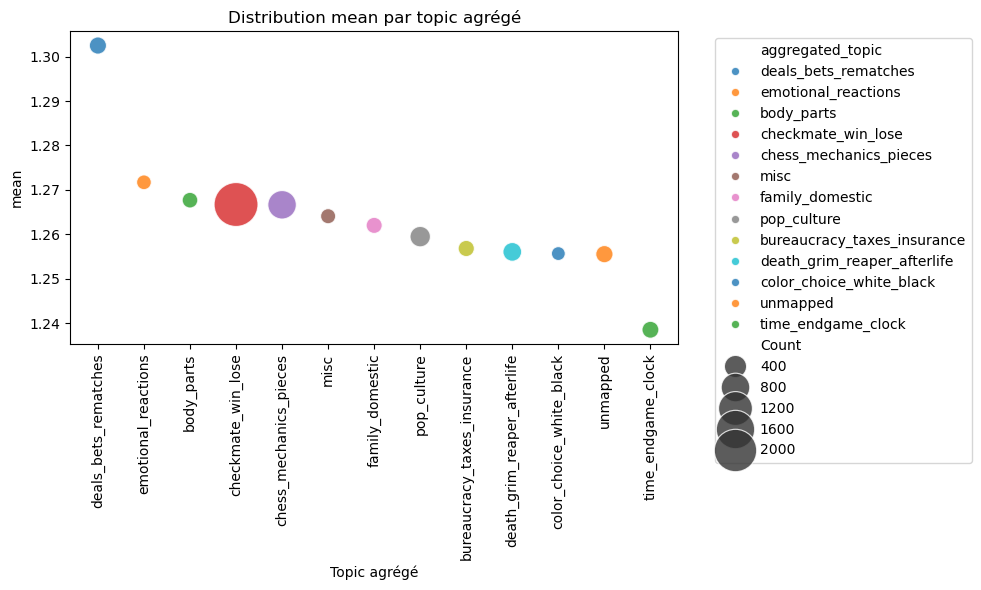

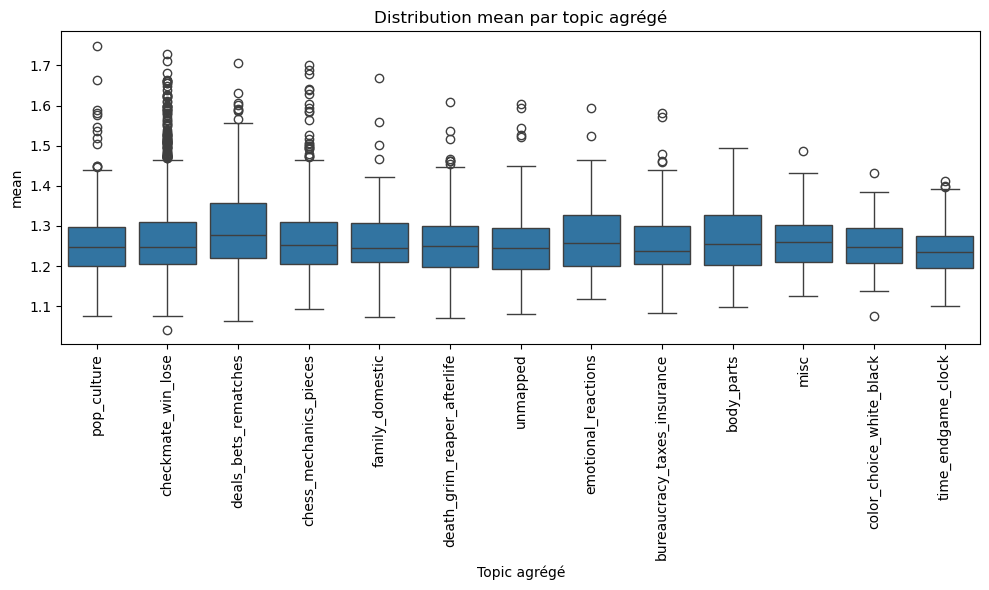

In [ ]:
# -------------------------------
# Compute stats
# -------------------------------
agg_topics_table = compute_aggregated_topic_info(df_topic_info, agg_topic_289)

df_full, df_scores = compute_topic_scores(
    df_topics,
    data_m,
    agg_topic_289,
    metric="mean" #"funny_score_scaled"
)

plot_topic_scores(df_full, df_scores, metric="mean") #"funny_score_scaled"


In [16]:
from src.utils.web_app_plots.app_plots import PWA

In [52]:
# PWA PLOTS

plots = {}
plots["topic_agg_scores"] = (PWA(title="mean_score distribution of caption by par aggregated topic",
                                    description="DESCRIPTION",
                                    X_label="Topic",
                                    Y_label="mean_score",
                                    X_data= df_scores["aggregated_topic"],
                                    Y_data= df_scores["mean"],
                                    plotParams={"xticks" : plt.xticks(rotation=90),
                                                "ylim" : plt.ylim(bottom=1, top=3),
                                                "legend_params" : plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'),
                                                "tight_layout" : plt.tight_layout(),
                                                "size":"Count", 
                                                "hue":"aggregated_topic",
                                                "sizes":(100, 1000),
                                                "alpha":0.8,
                                                "palette":"tab10"}
                                    ))

PWA.add_plots(plots)

NameError: name 'PWA' is not defined

### evaluer si mon score de similarité est élevé selon les clustered topics :

In [ ]:
# ici j'essaie d'évaluer le clustering avec la fonction de similarité que j'avais faite au début du MS2
# --> il faut que je modifie la fonction cluster_model.evaluate_intra_cluster_similarity ! pour prendre en entrée le df_full et calculer par cluster (topic value) la similarité
# df_full.groupby("topic").apply(cluster_model.evaluate_intra_cluster_similarity(df_full) marcherait peut être ???

cluster_model = CaptionClustering()
cluster_model.cluster_captions(df_full)
sim_results = cluster_model.evaluate_intra_cluster_similarity(df_full, plot=[0, 1, 2])

### Biais de distribution "long tail"
Tu as raison : si chaque cluster contient beaucoup de captions médiocres et quelques perles rares, la moyenne écrase tout. Il faut donc regarder au-delà de la moyenne.\
Regarde le ratio de captions "funny" dans chaque cluster\
Trace des boxplots ou violin plots par cluster pour voir les distributions complètes\

--> la moyenne peut masquer le fait qu’un cluster contient surtout des captions médiocres + quelques perles.

--> Solution appliquée : regarder proportion≥threshold, box/violin plots, percentile stratification et enrichment (top 10% distribution).

Variance et outliers :

Calcule la variance/écart-type du score de funniness par cluster
Certains clusters ont peut-être plus de variance = plus de potentiel pour des blagues excellentes mais risquées

--> calculé std/var/IQR et compté les outliers. Les clusters avec haute variance peuvent être intéressants (potentiel de perles) même si la moyenne est moyenne/faible.

### Stratification par niveau d'humour :

Isole les top 10% ou 20% des captions les plus drôles et regarde leur distribution thématique
Fais la même chose avec les captions moyennes (percentile 40-60)
Compare si certains topics sont sur-représentés dans le top vs la moyenne


--> La fonction stratify_percentiles_and_compare isole le top X% et la tranche moyenne (40–60) et calcule l’enrichissement par topic (top proportion vs overall proportion).

Cela répond directement à « quels topics produisent le plus de captions excellentes ? » sans utiliser la moyenne.

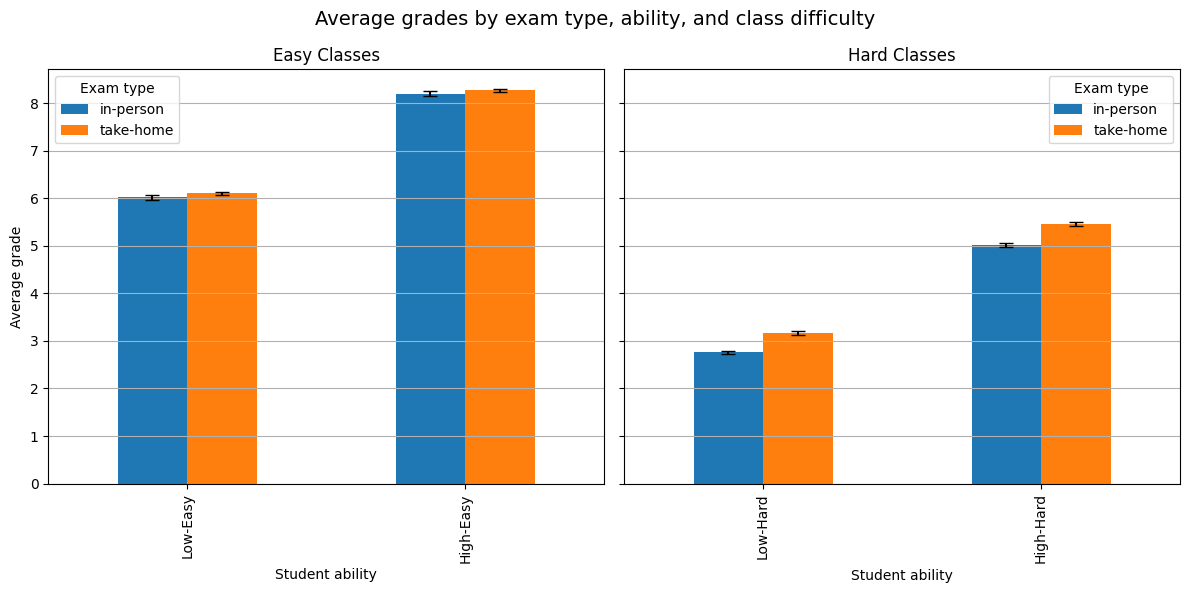

In [33]:
res, pval = stats.indttest()

# Kruskal-Wallis global pour tester si les distributions diffèrent entre topics (non-paramétrique).
#Tests pairwise Mann-Whitney pour paires, avec correction Bonferroni (tu peux remplacer par Holm ou test de Dunn si tu préfères).

NameError: name 'stats' is not defined

### Approche alternative
Au lieu de regarder "quel topic est le plus drôle en moyenne", tu pourrais poser la question : "quels topics produisent le plus de captions excellentes ?" en regardant le taux de succès (défini par un threshold ?) plutôt que le score moyen.


In [53]:
from itertools import combinations
import math
from scipy import stats


# -------------------------------
# 4) Variance and outlier analysis
# -------------------------------
def compute_variance_stats(df_full, metric="funny_score_scaled"):
    """
    Compute variance, IQR, and number of extreme outliers per aggregated topic.
    """
    groups = df_full.groupby("aggregated_topic")
    rows = []
    for name, g in groups:
        vals = g[metric].dropna().values
        if len(vals)==0:
            continue
        q1, q3 = np.percentile(vals, [25,75])
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        n_outliers = ((vals < lower) | (vals > upper)).sum()
        rows.append({
            "aggregated_topic": name,
            "count": len(vals),
            "mean": np.mean(vals),
            "median": np.median(vals),
            "std": np.std(vals, ddof=1),
            "var": np.var(vals, ddof=1),
            "iqr": iqr,
            "n_outliers": int(n_outliers)
        })
    return pd.DataFrame(rows).sort_values("mean", ascending=False)

# -------------------------------
# 5) Plotting functions (matplotlib-only)
# -------------------------------
def plot_box_and_violin(df_full, metric="funny_score_scaled", figsize=(12,6), order=None):
    """
    Plot side-by-side boxplots and violin plots for each aggregated topic.
    """
    plt.figure(figsize=figsize)
    agg_names = order if order is not None else sorted(df_full["aggregated_topic"].unique())
    # Prepare data in order
    data = [df_full.loc[df_full["aggregated_topic"]==a, metric].dropna().values for a in agg_names]
    # Boxplot
    plt.subplot(1,2,1)
    plt.boxplot(data, labels=agg_names, vert=True, showfliers=True)
    plt.xticks(rotation=90)
    plt.title("Boxplots par topic agrégé")
    plt.ylabel(metric)
    # Violin plot
    plt.subplot(1,2,2)
    plt.violinplot(data, showmeans=False, showmedians=True)
    plt.xticks(range(1, len(agg_names)+1), agg_names, rotation=90)
    plt.title("Violin plots par topic agrégé")
    plt.tight_layout()
    plt.show()

def plot_proportion_above_threshold(df_full, threshold=1.5, metric="funny_score_scaled", figsize=(10,5)):
    df = df_full.copy()
    df["above"] = (df[metric] >= threshold).astype(int)
    prop = df.groupby("aggregated_topic")["above"].agg(["mean","sum","count"]).reset_index().rename(columns={"mean":"prop_above","sum":"n_above"})
    prop = prop.sort_values("prop_above", ascending=False)
    plt.figure(figsize=figsize)
    plt.bar(prop["aggregated_topic"], prop["prop_above"])
    plt.xticks(rotation=90)
    plt.ylabel(f"Proportion >= {threshold}")
    plt.title(f"Proportion of captions >= {threshold} by aggregated topic")
    plt.tight_layout()
    plt.show()
    return prop

# -------------------------------
# 6) Stratification by percentiles and enrichment
# -------------------------------
def stratify_percentiles_and_compare(df_full, top_pct=10, middle_pct=(40,60), metric="funny_score_scaled"):
    """
    Returns dataframes for top N% and middle percentile and computes counts per aggregated topic,
    plus simple enrichment ratios (top proportion / overall proportion).
    """
    df = df_full.copy()
    df = df.dropna(subset=[metric])
    n = len(df)
    top_k = int(math.ceil(n * top_pct / 100.0))
    # get top by metric
    df_sorted = df.sort_values(metric, ascending=False).reset_index(drop=True)
    df_top = df_sorted.iloc[:top_k]
    # middle pct
    lo = int(math.floor(n * (middle_pct[0]/100.0)))
    hi = int(math.ceil(n * (middle_pct[1]/100.0)))
    df_middle = df_sorted.iloc[lo:hi]
    # counts per topic
    top_counts = df_top["aggregated_topic"].value_counts().rename("top_count").reset_index().rename(columns={"index":"aggregated_topic"})
    mid_counts = df_middle["aggregated_topic"].value_counts().rename("mid_count").reset_index().rename(columns={"index":"aggregated_topic"})
    overall = df["aggregated_topic"].value_counts().rename("overall_count").reset_index().rename(columns={"index":"aggregated_topic"})
    merged = overall.merge(top_counts, on="aggregated_topic", how="left").merge(mid_counts, on="aggregated_topic", how="left").fillna(0)
    merged["top_prop"] = merged["top_count"]/merged["overall_count"]
    merged["mid_prop"] = merged["mid_count"]/merged["overall_count"]
    merged["enrichment_top_vs_overall"] = (merged["top_count"] / top_k) / (merged["overall_count"] / n)
    merged = merged.sort_values("enrichment_top_vs_overall", ascending=False)
    return df_top, df_middle, merged

# -------------------------------
# 7) Statistical tests
# -------------------------------
def kruskal_test(df_full, metric="funny_score_scaled"):
    """
    Kruskal-Wallis test across aggregated topics (non-parametric ANOVA).
    Returns H-stat and p-value and group medians.
    """
    groups = [g[metric].dropna().values for n,g in df_full.groupby("aggregated_topic")]
    names = [n for n,_ in df_full.groupby("aggregated_topic")]
    # only keep groups with at least 5 values
    filtered = [(names[i], groups[i]) for i in range(len(groups)) if len(groups[i])>=5]
    if len(filtered) < 2:
        return None
    arrays = [arr for n,arr in filtered]
    H, p = stats.kruskal(*arrays)
    medians = {n: np.median(arr) for n,arr in filtered}
    return {"H": H, "p": p, "medians": medians}

def pairwise_mannwhitney(df_full, metric="funny_score_scaled", alpha=0.05):
    """
    Pairwise Mann-Whitney U tests with Bonferroni correction.
    Returns a dataframe of pairs and adjusted p-values.
    """
    groups = {name: g[metric].dropna().values for name,g in df_full.groupby("aggregated_topic") if len(g[metric].dropna())>=5}
    pairs = []
    names = list(groups.keys())
    m = len(names)
    for i,j in combinations(range(m),2):
        a = groups[names[i]]
        b = groups[names[j]]
        stat, p = stats.mannwhitneyu(a,b, alternative='two-sided')
        pairs.append({"group1": names[i], "group2": names[j], "U": stat, "p_raw": p})
    # Bonferroni
    for row in pairs:
        row["p_adj_bonf"] = min(row["p_raw"] * len(pairs), 1.0)
    df_pairs = pd.DataFrame(pairs).sort_values("p_adj_bonf")
    return df_pairs


C:\Users\cyrie\AppData\Local\Temp\ipykernel_4660\414793194.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=agg_names, vert=True, showfliers=True)


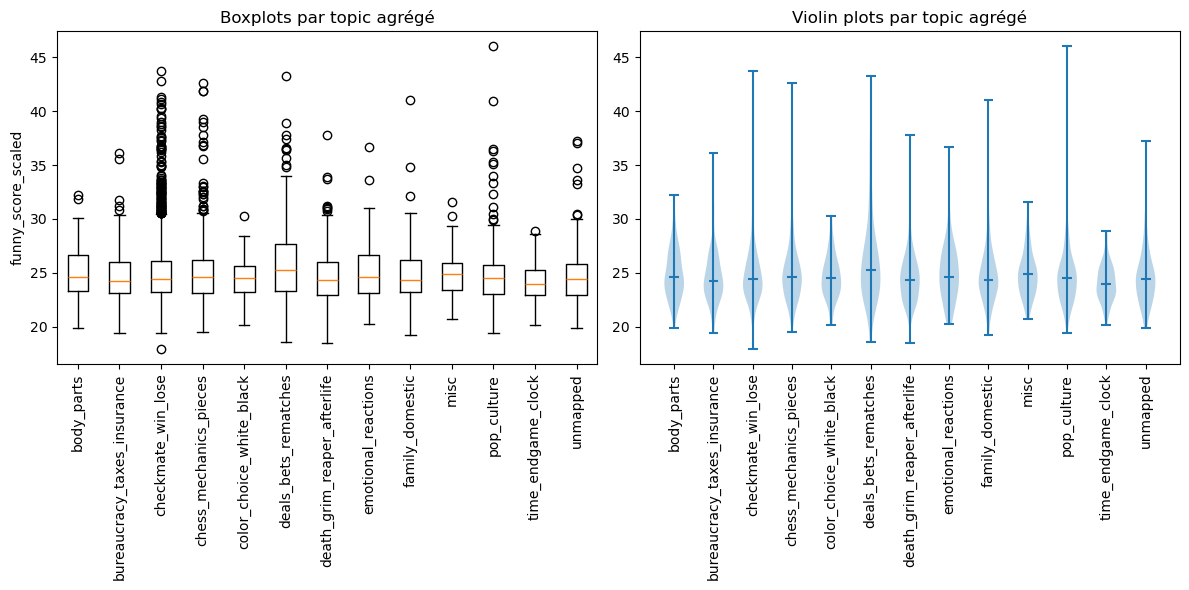

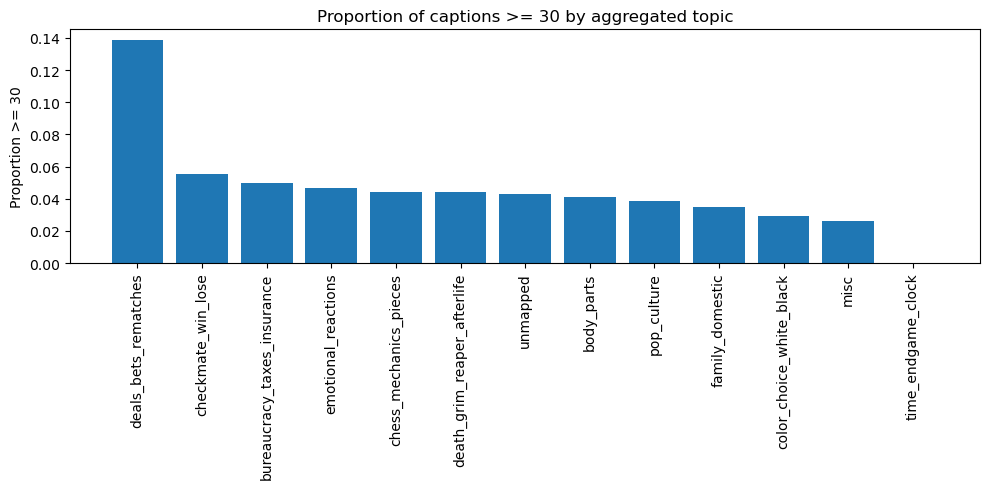

,aggregated_topic,prop_above,n_above,count
5,deals_bets_rematches,0.138365,22,159
2,checkmate_win_lose,0.055556,120,2160
1,bureaucracy_taxes_insurance,0.050000,6,120
7,emotional_reactions,0.046875,3,64
3,chess_mechanics_pieces,0.044192,35,792
6,death_grim_reaper_afterlife,0.043860,10,228
12,unmapped,0.043210,7,162
0,body_parts,0.040816,4,98
10,pop_culture,0.038835,12,309
8,family_domestic,0.034783,4,115


In [60]:
df_full, df_scores = compute_topic_scores(df_topics, data_m, agg_topic_289, metric="funny_score_scaled")

df_var = compute_variance_stats(df_full, metric="funny_score_scaled")


kw_res = kruskal_test(df_full, metric="funny_score_scaled")
pairwise_res = pairwise_mannwhitney(df_full, metric="funny_score_scaled")
# Print summary stats
#print("Kruskal-Wallis test (H, p):", None if kw_res is None else (kw_res["H"], kw_res["p"]))
#print("Top 5 aggregated topics by proportion of >=0.9:", prop.head())



df_top, df_mid, enrichment = stratify_percentiles_and_compare(df_full, metric="funny_score_scaled", top_pct=10, middle_pct=(40,60))



plot_box_and_violin(df_full, metric="funny_score_scaled")
plot_proportion_above_threshold(df_full, threshold=30, metric="funny_score_scaled")

# CE QUE JAVAIS FAIT AVANT LA REU KIMACASSE:

In [ ]:
# Just perform a 'naive' analysis on a random sample from a single cartoon for the moment. 
df = dataA[150].copy()
sample_size = None
if sample_size and len(df) > sample_size:
    df = df.sample(sample_size, random_state=42).reset_index(drop=True)

***To access to the definitions and content of classes SimilarityModel,***\
***CaptionClustering, SimilarHumorAnalysis, please see : [here](src\models\similarity_analysis.py)***

In [6]:
cluster_model = CaptionClustering()
cluster_model.cluster_captions(df)

results_benchmark_clustering_algo = cluster_model.benchmark_clustering_algorithms()

SBERT encoding with 'all-MiniLM-L6-v2'


Batches: 100%|██████████| 243/243 [00:53<00:00,  4.54it/s]


Clustering with KMEANS
=== Running clustering benchmark ===

→ Testing KMeans...

→ Testing Agglomerative...

→ Testing DBSCAN...

→ Testing spectral...

=== Benchmark completed ===
       algorithm  n_clusters  silhouette    time_sec error
0         KMeans        1000    0.081084   28.227829  None
1  Agglomerative        1000    0.115442   12.328522  None
2         DBSCAN           0         NaN    1.140609  None
3       spectral        1000    0.075037  578.557219  None


In [ ]:
"""
n = 10
=== Benchmark completed ===
       algorithm  n_clusters  silhouette    time_sec error
0         KMeans          10    0.087315    0.807191  None
1  Agglomerative          10    0.048412   35.531559  None
2         DBSCAN           0         NaN    2.191594  None
3  agglomerative          10    0.048412   24.143446  None
4       spectral          10   -0.026003  134.604343  None
"""

"""
n = 50
=== Benchmark completed ===
       algorithm  n_clusters  silhouette   time_sec error
0         KMeans          50    0.087599   2.035328  None
1  Agglomerative          50    0.048528  13.818463  None
2         DBSCAN           0         NaN   1.461815  None
3       spectral          50    0.017589  76.105654  None
"""

"""
n = 1000
=== Benchmark completed ===
       algorithm  n_clusters  silhouette    time_sec error
0         KMeans        1000    0.081084   28.227829  None
1  Agglomerative        1000    0.115442   12.328522  None
2         DBSCAN           0         NaN    1.140609  None
3       spectral        1000    0.075037  578.557219  None
"""

'=== Benchmark completed ===\n       algorithm  n_clusters  silhouette   time_sec error\n0         KMeans          50    0.087599   2.035328  None\n1  Agglomerative          50    0.048528  13.818463  None\n2         DBSCAN           0         NaN   1.461815  None\n3       spectral          50    0.017589  76.105654  None\n'

In [25]:
# 1.Clustering

# IMPLEMENTER ELBOW METHOD POUR TROUVER LE NOMBRE DE CLUSTER OPTIMAL
cluster_model = CaptionClustering(model_name='all-MiniLM-L6-v2', n_clusters=50, normalize=True)

cluster_labels, embeddings = cluster_model.cluster_captions(df)
#df_clusters = cluster_model.UMAP_reduction(df, umap_n_components=3, umap_n_neighbors=15, umap_min_dist=0.1, umap_metric='cosine')


SBERT encoding with 'all-MiniLM-L6-v2'


Batches: 100%|██████████| 243/243 [00:30<00:00,  7.94it/s]


Clustering with KMEANS


Cluster 14: 143 captions — mean combined similarity = 0.572


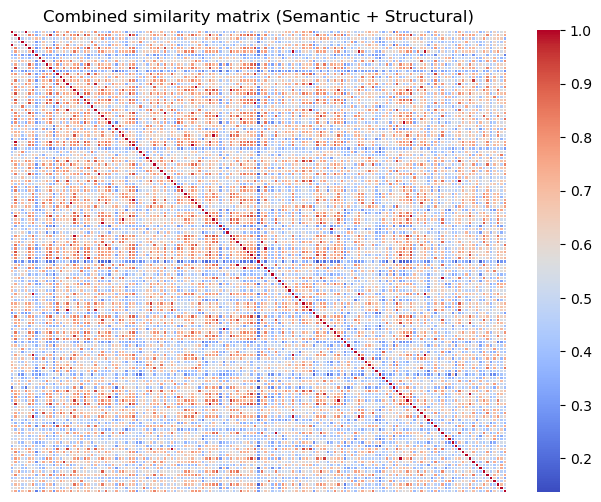

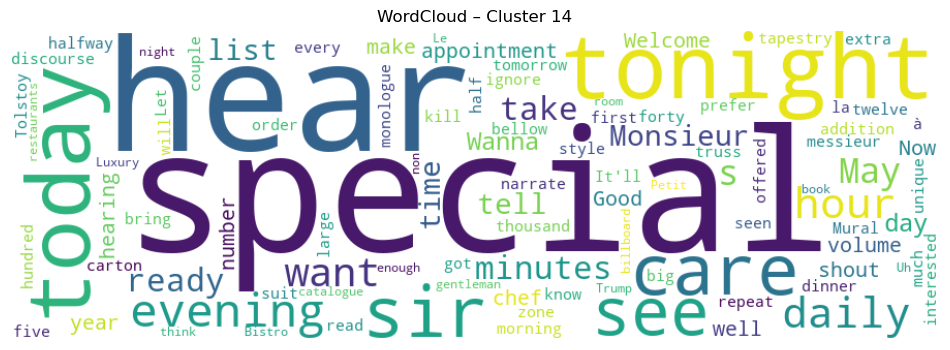

Representative caption: 'Would you like to hear the specials?',
(cosinus only) similarity to centroid = 0.94
cluster_id: 14
n_items: 143
avg_caption_length: 9.06
std_caption_length: 2.23
avg_similarity_to_centroid: 0.78
min_similarity: 0.38
max_similarity: 0.94
Cluster 43: 70 captions — mean combined similarity = 0.366


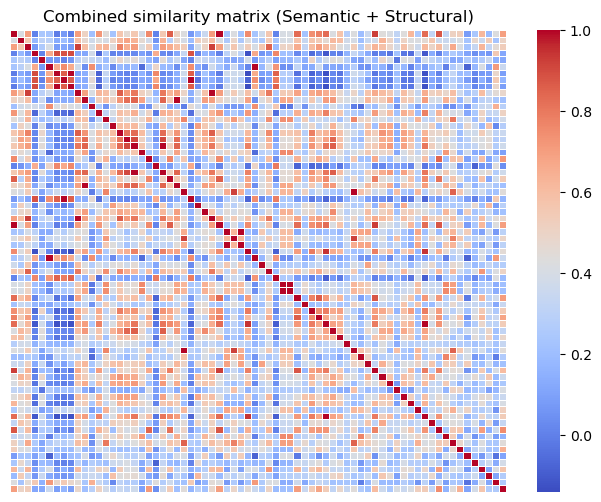

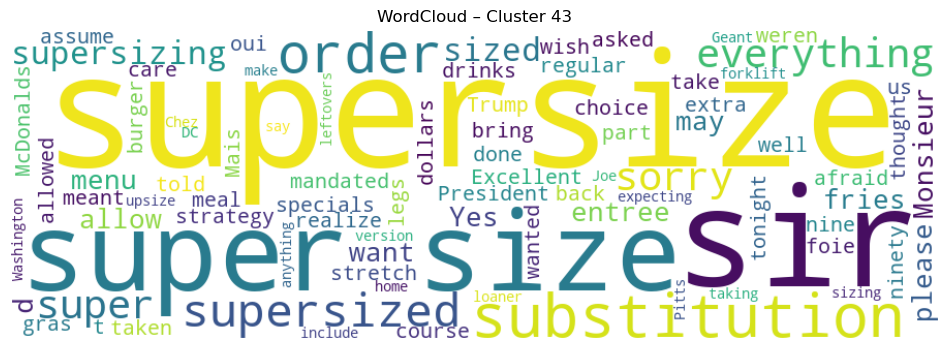

Representative caption: 'Would you like to supersize that, sir?',
(cosinus only) similarity to centroid = 0.85
cluster_id: 43
n_items: 70
avg_caption_length: 6.79
std_caption_length: 3.13
avg_similarity_to_centroid: 0.59
min_similarity: 0.30
max_similarity: 0.85
Cluster 44: 74 captions — mean combined similarity = 0.529


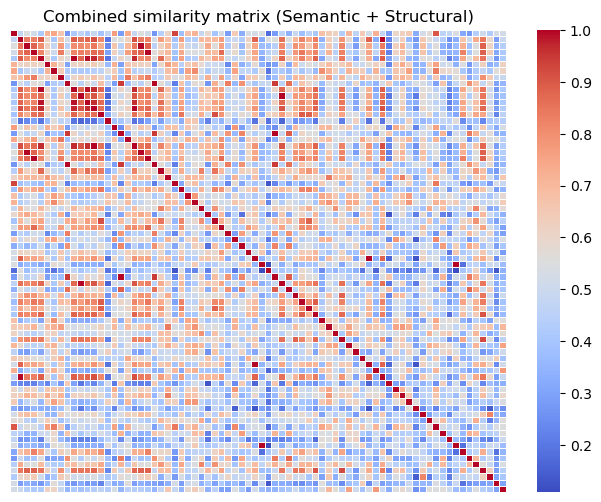

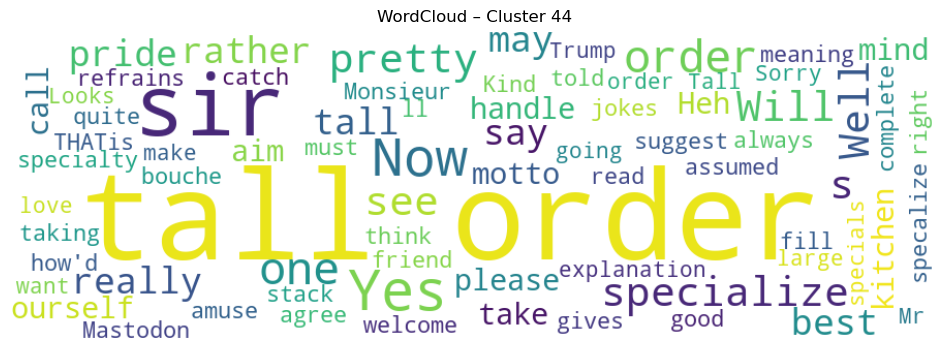

Representative caption: 'That's a tall order, sir.',
(cosinus only) similarity to centroid = 0.91
cluster_id: 44
n_items: 74
avg_caption_length: 7.88
std_caption_length: 2.88
avg_similarity_to_centroid: 0.76
min_similarity: 0.43
max_similarity: 0.91
Cluster 49: 152 captions — mean combined similarity = 0.210


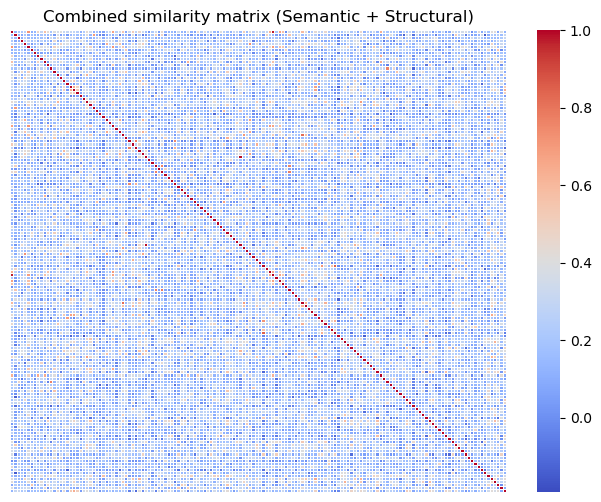

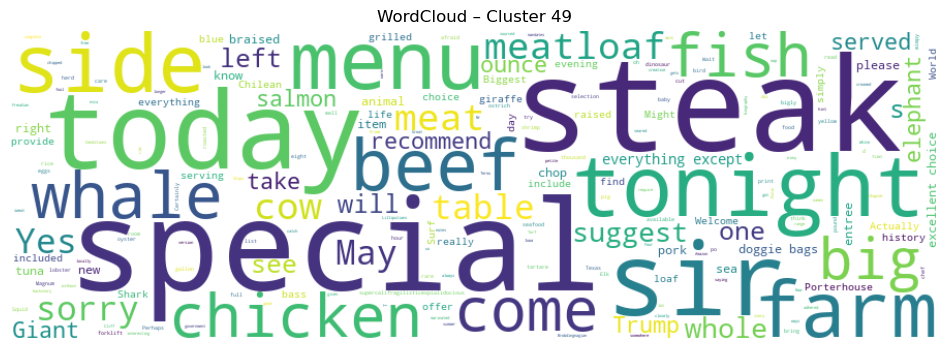

Representative caption: 'The special today is side of beef.',
(cosinus only) similarity to centroid = 0.59
cluster_id: 49
n_items: 152
avg_caption_length: 10.85
std_caption_length: 5.17
avg_similarity_to_centroid: 0.38
min_similarity: 0.18
max_similarity: 0.59


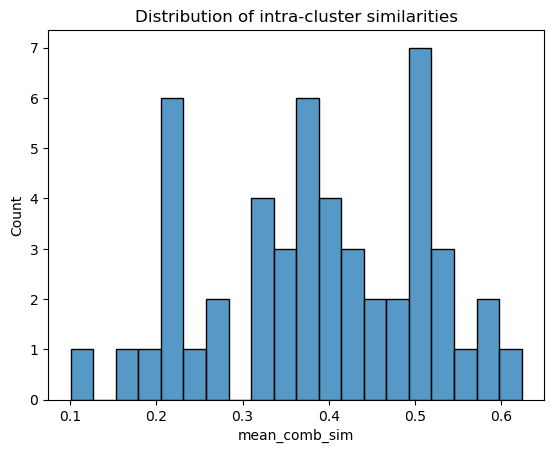

In [14]:
# 2 Analysis of similarity of captions within each clusters to see if the clustering with kNN is working or assigning not good clusters
sim_results = cluster_model.evaluate_intra_cluster_similarity(df, plot=[14, 43, 44, 49])

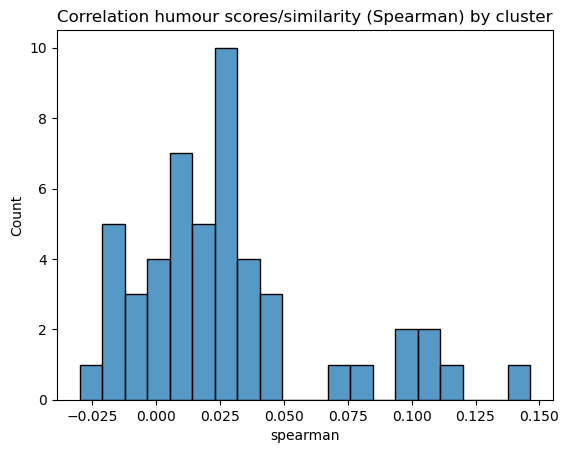

In [ ]:
# 3 Analysis of humour score correlation within a similarity cluster
humor_analysis = SimilarHumorAnalysis(model_name='all-MiniLM-L6-v2')
corr_results = humor_analysis.scores_correlation_by_cluster(df_clusters, humor_col='mean')
#print(corr_results.sort_values('spearman', ascending=False).head())

### 3.3. Comments

We see a possible clusterisation, with intra-cluster homogeneity concerning the similarity metric (see heatmaps). The results are not the most satisfactory for the moment :
- Results of similarity homogeneity depends a lot of the cluster : some contains very similar captions, some not (see histogram of distribution).
- The naive correlation analysis shows mainly no correlation between the clusters of captions and the scores obtained within the cluster, some clusters have a very small correlation.

The models will be enhanced with fine-tuning of the SBERT model and Kmeans hyperparameters (e.g. choosing adequate number of cluster with Elbow method, distance metric...).


Limitations of this similarity metric, that has to be adressed for milestone 3:
- SBERT embeddings don't capture all humor, they "only" capture semantic proximity, not humorous style (e.g., irony, absurdity, subversion, etc.). --> Two captions that are very funny for the same reason (e.g., puns) can be very far apart semantically.

- Intra-cluster similarity isn't always enough: a cluster can be "compact" (high average similarity) but thematically irrelevant (e.g., very banal or repetitive captions).